# Tarea 1 - Taller de Deep Learning

**Johny Kidd: 228175**  



# Imports


In [1]:
# Core Python
import os
import random
import numpy as np
from collections import Counter


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Weights & Biases
import wandb
wandb.login() 


Usando device: cuda


wandb: Currently logged in as: kidnixt (kidnixt-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Seteo de Variables

In [2]:
BATCH_SIZE = 128
NUM_WORKERS = 2
# Esto obliga a W&B a usar C:\wandb_temp en lugar de la ruta bloqueada de AppData.
os.environ["WANDB_DATA_DIR"] = "C:\\wandb_temp" 
print(f"DEBUG: WANDB_DATA_DIR ha sido forzada a: {os.environ['WANDB_DATA_DIR']}")

DEBUG: WANDB_DATA_DIR ha sido forzada a: C:\wandb_temp


# 1. Carga de Dataset


In [3]:
transform = transforms.Compose([
    transforms.Resize((160, 160)), 
    transforms.ToTensor()
])

# Cargamos Imagenette 160px
train_dataset = datasets.Imagenette(
    root="./data", size="160px", split="train", download=False, transform=transform
)
val_dataset = datasets.Imagenette(
    root="./data", size="160px", split="val", download=False, transform=transform
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Clases: {train_dataset.classes}")


Train size: 9469
Val size: 3925
Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


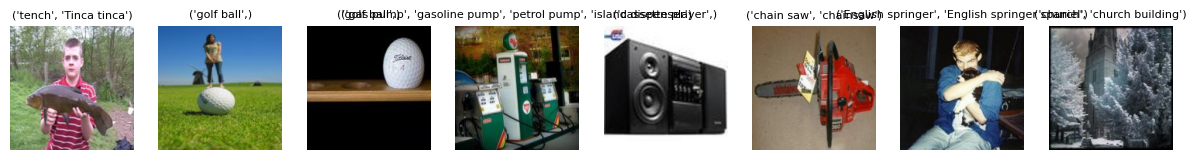

In [5]:
# Mostrar algunos ejemplos de imágenes
def show_samples(dataset, n=8):
    indices = np.random.choice(len(dataset), n, replace=False)  # Selecciona índices aleatorios
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(dataset.classes[label], fontsize=8)
        axes[i].axis("off")
    plt.show()

show_samples(train_dataset)

# 3. Análisis Exploratorio de Datos (EDA)

## Balanceo de Clases

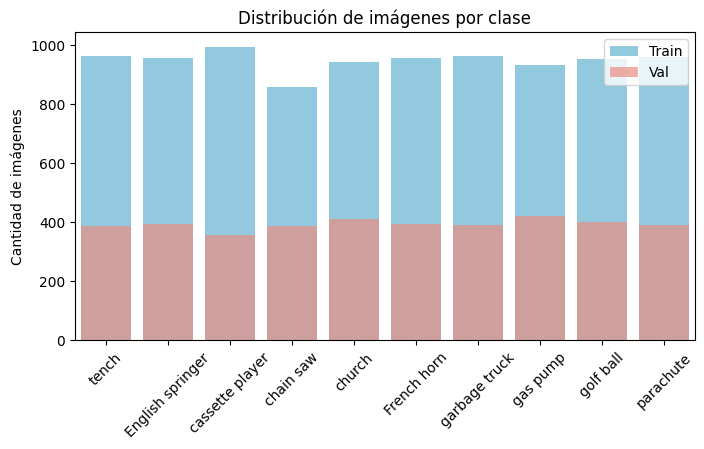

In [6]:
class_names = train_dataset.classes
class_names_simple = [c[0] if isinstance(c, tuple) else c for c in class_names]

train_labels = [label for _, label in train_dataset._samples]
val_labels = [label for _, label in val_dataset._samples]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

train_distribution = [train_counts[i] for i in range(len(class_names))]
val_distribution = [val_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(8,4))
sns.barplot(x=class_names_simple, y=train_distribution, color="skyblue", label="Train")
sns.barplot(x=class_names_simple, y=val_distribution, color="salmon", alpha=0.7, label="Val")
plt.xticks(rotation=45)
plt.title("Distribución de imágenes por clase")
plt.ylabel("Cantidad de imágenes")
plt.legend()
plt.show()


## Tamaño y Aspect Ratio

Ancho: mean=160.0, std=0.0, min=160, max=160
Alto: mean=160.0, std=0.0, min=160, max=160
Aspect ratio: mean=1.00, std=0.00, min=1.00, max=1.00


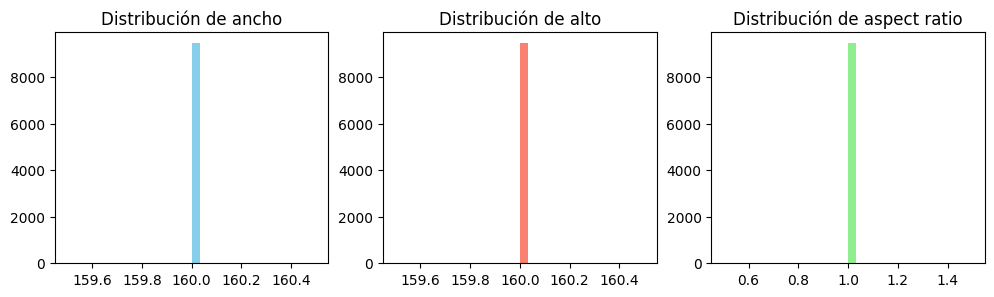

In [7]:

widths, heights, aspect_ratios = [], [], []


for img, _ in train_dataset:
    pil_img = transforms.ToPILImage()(img)
    w, h = pil_img.size  
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)

widths = np.array(widths)
heights = np.array(heights)
aspect_ratios = np.array(aspect_ratios)

print("Ancho: mean={:.1f}, std={:.1f}, min={}, max={}".format(widths.mean(), widths.std(), widths.min(), widths.max()))
print("Alto: mean={:.1f}, std={:.1f}, min={}, max={}".format(heights.mean(), heights.std(), heights.min(), heights.max()))
print("Aspect ratio: mean={:.2f}, std={:.2f}, min={:.2f}, max={:.2f}".format(aspect_ratios.mean(), aspect_ratios.std(), aspect_ratios.min(), aspect_ratios.max()))

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Distribución de ancho")

plt.subplot(1,3,2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Distribución de alto")

plt.subplot(1,3,3)
plt.hist(aspect_ratios, bins=30, color='lightgreen')
plt.title("Distribución de aspect ratio")

plt.show()


## Media y Desviación Estándar de canales de color

Media por canal RGB: tensor([0.4625, 0.4580, 0.4298])
Desviación estándar por canal RGB: tensor([0.2748, 0.2690, 0.2856])


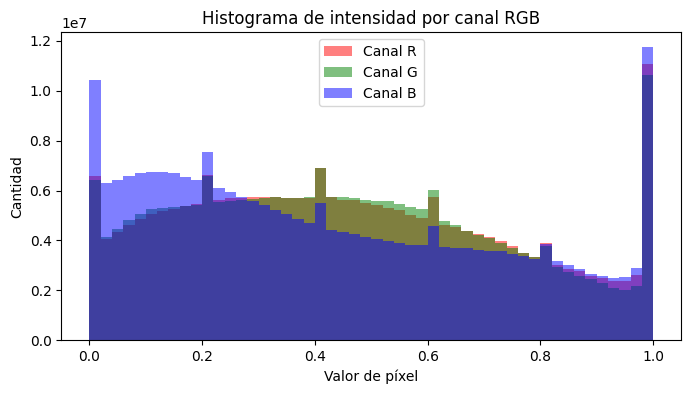

In [8]:
means = []
stds = []

#iteramos por batchss para no sarturar memoria
loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

for imgs, _ in loader:
    means.append(imgs.mean(dim=[0,2,3]))  # mean por canal
    stds.append(imgs.std(dim=[0,2,3]))    # std por canal

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

print("Media por canal RGB:", mean)
print("Desviación estándar por canal RGB:", std)

# Histograma de intensidad por canal
all_pixels = []
for imgs, _ in loader:
    all_pixels.append(imgs)

all_pixels = torch.cat(all_pixels, dim=0)  # shape [N, C, H, W]

plt.figure(figsize=(8,4))
colors = ['r','g','b']
for i, color in enumerate(colors):
    plt.hist(all_pixels[:,i,:,:].numpy().flatten(), bins=50, color=color, alpha=0.5, label=f'Canal {color.upper()}')
plt.title("Histograma de intensidad por canal RGB")
plt.xlabel("Valor de píxel")
plt.ylabel("Cantidad")
plt.legend()
plt.show()


## Calidads de las imágenes

Iniciando el análisis de calidad detallado en 9469 imágenes...
--------------------------------------------------
Total de imágenes analizadas: 9469

--- Desglose de Problemas (Superpuestos) ---
1. Borrosidad (<10.0):      2 (0.02%)
2. Muy Oscuras (<30.0):    45 (0.48%)
3. Muy Brillantes (>220.0): 60 (0.63%)
4. Bajo Contraste (<15.0): 59 (0.62%)

--- Resumen General ---
Imágenes con MÚLTIPLES problemas (>=2): 2 (0.02%)
Imágenes problemáticas TOTALES (>=1):    164 (1.73%)
--------------------------------------------------


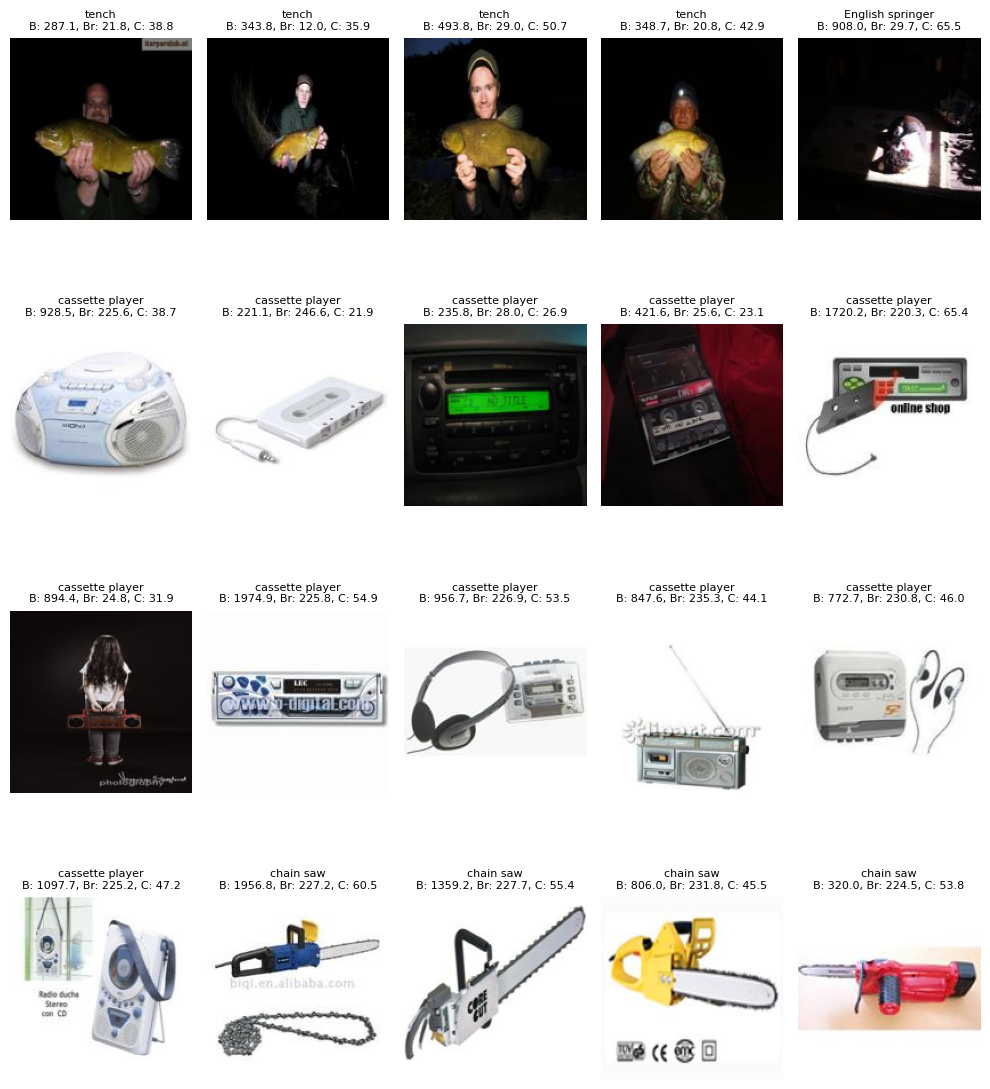

In [10]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- Definición de Funciones de Puntuación ---
def blur_score(img):
    """Calcula el score de borrosidad usando la Varianza del Laplaciano."""
    img_gray = np.array(img.convert('L'))
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

def brightness_score(img):
    """Calcula el brillo promedio (media del píxel) en escala de grises."""
    img_gray = np.array(img.convert('L'))
    return img_gray.mean()

def contrast_score(img):
    """Calcula el contraste (desviación estándar) en escala de grises."""
    img_gray = np.array(img.convert('L'))
    return img_gray.std()

# --- Umbrales (los que definiste) ---
blur_threshold = 10      # <10: borrosa
dark_threshold = 30      # <30: muy oscura
bright_threshold = 220   # >220: muy brillante
contrast_threshold = 15  # <15: poco contraste

# --- Lógica de Conteo Detallado ---
total_images = len(train_dataset)

# Contadores para cada tipo de problema (pueden superponerse)
count_blur = 0
count_dark = 0
count_bright = 0
count_low_contrast = 0
count_multiple_problems = 0
total_problem_count = 0

problem_images_examples = [] # Para guardar un máximo de 20 ejemplos para plotear

print(f"Iniciando el análisis de calidad detallado en {total_images} imágenes...")

# Iterar sobre todo el dataset de entrenamiento
for i, (img, label) in enumerate(train_dataset):
    # Asegurarse de tener una imagen PIL para los cálculos
    pil_img = img if isinstance(img, Image.Image) else transforms.ToPILImage()(img)
    
    blur = blur_score(pil_img)
    bright = brightness_score(pil_img)
    contrast = contrast_score(pil_img)
    
    current_problems = 0
    is_problematic = False
    
    # 1. Borrosidad
    if blur < blur_threshold:
        count_blur += 1
        current_problems += 1
        is_problematic = True

    # 2. Brillo (Oscuro)
    if bright < dark_threshold:
        count_dark += 1
        current_problems += 1
        is_problematic = True

    # 3. Brillo (Brillante)
    if bright > bright_threshold:
        count_bright += 1
        current_problems += 1
        is_problematic = True

    # 4. Contraste (Bajo)
    if contrast < contrast_threshold:
        count_low_contrast += 1
        current_problems += 1
        is_problematic = True

    # Contar si tiene MÚLTIPLES problemas (2 o más)
    if current_problems >= 2:
        count_multiple_problems += 1
        
    # Contar el total de imágenes con AL MENOS un problema
    if is_problematic:
        total_problem_count += 1
        # Guardar ejemplos solo si no hemos alcanzado el límite de 20
        if len(problem_images_examples) < 20:
            problem_images_examples.append((pil_img, label, blur, bright, contrast))


# --- Resultados del Conteo ---
def get_percentage(count, total):
    return (count / total) * 100

print("-" * 50)
print(f"Total de imágenes analizadas: {total_images}")
print("\n--- Desglose de Problemas (Superpuestos) ---")
print(f"1. Borrosidad (<{blur_threshold:.1f}):      {count_blur} ({get_percentage(count_blur, total_images):.2f}%)")
print(f"2. Muy Oscuras (<{dark_threshold:.1f}):    {count_dark} ({get_percentage(count_dark, total_images):.2f}%)")
print(f"3. Muy Brillantes (>{bright_threshold:.1f}): {count_bright} ({get_percentage(count_bright, total_images):.2f}%)")
print(f"4. Bajo Contraste (<{contrast_threshold:.1f}): {count_low_contrast} ({get_percentage(count_low_contrast, total_images):.2f}%)")

print("\n--- Resumen General ---")
print(f"Imágenes con MÚLTIPLES problemas (>=2): {count_multiple_problems} ({get_percentage(count_multiple_problems, total_images):.2f}%)")
print(f"Imágenes problemáticas TOTALES (>=1):    {total_problem_count} ({get_percentage(total_problem_count, total_images):.2f}%)")
print("-" * 50)

# --- Visualización de Ejemplos ---
# (El código de visualización de ejemplos sigue siendo el mismo)
if problem_images_examples:
    num_plots = len(problem_images_examples)
    rows = (num_plots + 4) // 5  # Calcular filas necesarias para 5 columnas
    
    fig, axes = plt.subplots(rows, 5, figsize=(10, 3 * rows))
    
    # Manejar el caso de una sola fila de plots
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) and axes.ndim > 1 else (axes.flatten() if isinstance(axes, np.ndarray) else [axes])
    
    for ax, (img, label, blur, bright, contrast) in zip(axes_flat, problem_images_examples):
        # Asumiendo que 'class_names_simple' está definido. Si no, usa f"Clase {label}"
        try:
            class_name = class_names_simple[label]
        except (NameError, TypeError):
            class_name = f"Clase {label}"

        ax.imshow(img)
        ax.set_title(f"{class_name}\nB: {blur:.1f}, Br: {bright:.1f}, C: {contrast:.1f}", fontsize=8)
        ax.axis('off')

    # Ocultar ejes sobrantes
    for i in range(num_plots, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron ejemplos problemáticos para plotear con los umbrales definidos.")

## Brillo, Contraste y Saturación

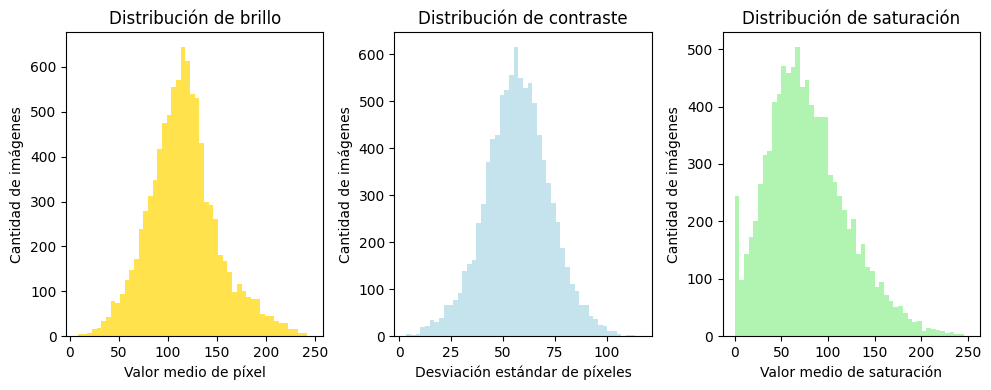

In [11]:

brightness_list = []
contrast_list = []
saturation_list = []

for img, _ in train_dataset:
    # Convertir a PIL si no lo es
    pil_img = img if isinstance(img, Image.Image) else transforms.ToPILImage()(img)
    
    # Convertir a array
    img_arr = np.array(pil_img)
    
    # Brillo y contraste (en escala de grises)
    gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
    brightness_list.append(gray.mean())
    contrast_list.append(gray.std())
    
    # Saturación promedio
    hsv = cv2.cvtColor(img_arr, cv2.COLOR_RGB2HSV)
    saturation_list.append(hsv[:,:,1].mean())

# Convertir a numpy
brightness_list = np.array(brightness_list)
contrast_list = np.array(contrast_list)
saturation_list = np.array(saturation_list)

# Histogramas
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.hist(brightness_list, bins=50, color='gold', alpha=0.7)
plt.title("Distribución de brillo")
plt.xlabel("Valor medio de píxel")
plt.ylabel("Cantidad de imágenes")

plt.subplot(1,3,2)
plt.hist(contrast_list, bins=50, color='lightblue', alpha=0.7)
plt.title("Distribución de contraste")
plt.xlabel("Desviación estándar de píxeles")
plt.ylabel("Cantidad de imágenes")

plt.subplot(1,3,3)
plt.hist(saturation_list, bins=50, color='lightgreen', alpha=0.7)
plt.title("Distribución de saturación")
plt.xlabel("Valor medio de saturación")
plt.ylabel("Cantidad de imágenes")

plt.tight_layout()
plt.show()


## Análisis del espectro de frecuencia (FFT)

In [12]:
import numpy as np
import cv2
from PIL import Image

def calcular_espectro_fft(img):
    """
    Calcula el espectro de magnitud de Fourier centrado de una imagen RGB/PIL/torch.Tensor.
    """
    # Convertir a PIL si es tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)  # C,H,W -> H,W,C
        img = (img * 255).astype(np.uint8)    # De [0,1] a [0,255]
    elif isinstance(img, Image.Image):
        img = np.array(img)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # FFT 2D y centrar frecuencia baja
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    
    # Magnitud logarítmica
    magnitude = 20 * np.log(np.abs(fshift) + 1e-8)  # epsilon para evitar log(0)
    return magnitude


In [13]:
from tqdm.notebook import tqdm 
import random

num_samples = min(9000, len(train_dataset))  # limitar muestra por velocidad
indices_muestra = random.sample(range(len(train_dataset)), num_samples)

# Inicializar con la primera imagen
espectro_acumulado = np.zeros_like(calcular_espectro_fft(train_dataset[0][0]))

print(f"Calculando espectro promedio sobre {num_samples} imágenes...")
for i in tqdm(indices_muestra):
    img, _ = train_dataset[i]
    espectro = calcular_espectro_fft(img)
    if espectro.shape == espectro_acumulado.shape:
        espectro_acumulado += espectro

espectro_promedio = espectro_acumulado / num_samples


Calculando espectro promedio sobre 9000 imágenes...


  0%|          | 0/9000 [00:00<?, ?it/s]

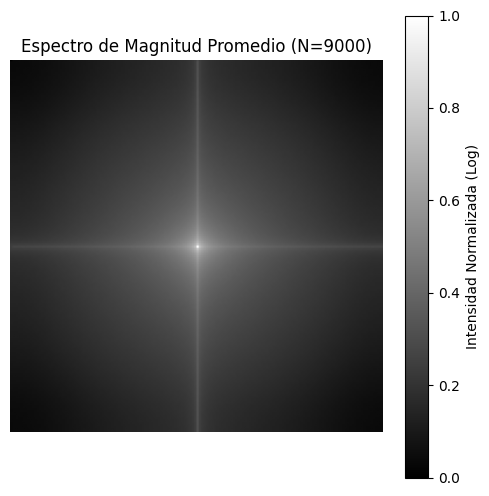

In [14]:
import matplotlib.pyplot as plt

espectro_norm = (espectro_promedio - np.min(espectro_promedio)) / (np.max(espectro_promedio) - np.min(espectro_promedio))

plt.figure(figsize=(6, 6))
plt.imshow(espectro_norm, cmap='gray')
plt.title(f'Espectro de Magnitud Promedio (N={num_samples})')
plt.colorbar(label='Intensidad Normalizada (Log)')
plt.axis('off')
plt.show()


## Estimación de ruido local

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
# Asumo que 'transforms' viene de PyTorch si usas un dataset estándar
try:
    import torchvision.transforms as transforms
except ImportError:
    # Definir un dummy si no se usa PyTorch (solo si no se requiere la conversión)
    class DummyTransform:
        def __call__(self, img):
            return img
    transforms = type('transforms', (object,), {'ToPILImage': lambda: DummyTransform()})()

# Celda 1: Cálculo de Ruido y Almacenamiento de Índices

# Parámetros para la estimación:
PATCH_SIZE = 10 
num_muestras_ruido = min(9000, len(train_dataset)) 

def estimar_ruido_local(image_rgb):
    """Estima el ruido como la desviación estándar local en la imagen."""
    
    # Manejo del formato de la imagen para cv2
    if image_rgb.dtype != np.uint8:
        # Asume que si no es uint8, está normalizada a 0-1, la escalamos.
        # Ajusta esta línea si sabes que tus arrays NumPy tienen otro rango (ej. 0-255 en float)
        image_rgb = (image_rgb * 255).astype(np.uint8) 
        
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    H, W = gray_image.shape
    
    if H < PATCH_SIZE or W < PATCH_SIZE:
         return 0 # Si es muy pequeña, la omitimos o asignamos un valor bajo
         
    varianzas_locales = []
    
    # Tomar 10 parches aleatorios en la imagen para estimar la variación local
    for _ in range(10): 
        x = np.random.randint(0, W - PATCH_SIZE)
        y = np.random.randint(0, H - PATCH_SIZE)
        
        patch = gray_image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
        varianzas_locales.append(np.std(patch))
        
    return np.mean(varianzas_locales)

# Almacenamos tuplas (índice, ruido_estimado)
ruidos_estimados_con_indice = []
print(f"Estimando ruido local en {num_muestras_ruido} imágenes...")

for i in tqdm(range(num_muestras_ruido)):
    # Asume que train_dataset[i] devuelve (imagen, etiqueta)
    img, _ = train_dataset[i] 
    
    # Manejo de formatos: si es un objeto Tensor/PIL, lo convertimos a NumPy array
    if not isinstance(img, np.ndarray):
        try:
            # Si es un Tensor de PyTorch, lo convertimos a NumPy (CHW -> HWC)
            # Nota: Esto asume el orden de canales de PyTorch
            img = np.array(transforms.ToPILImage()(img))
        except:
             # Si falla la conversión a PIL/NumPy (caso extremo), usamos el array directamente si es posible
             if hasattr(img, 'numpy'):
                 img = img.numpy().transpose((1, 2, 0))
             else:
                 img = np.array(img)
    
    ruido_est = estimar_ruido_local(img)
    ruidos_estimados_con_indice.append((i, ruido_est))

# Convertir a array NumPy para cálculos estadísticos
ruidos_array = np.array([r[1] for r in ruidos_estimados_con_indice])
media_ruido = np.mean(ruidos_array)
std_ruido = np.std(ruidos_array)

print("\n--- Resultados Estadísticos ---")
print(f"Media ($\mu$): {media_ruido:.2f}, Desviación Estándar ($\sigma$): {std_ruido:.2f}")

# --- Identificación de Outliers (Para la visualización) ---
umbral_alto = media_ruido + 2 * std_ruido
indices_ruido_alto = [
    i for i, ruido in ruidos_estimados_con_indice if ruido > umbral_alto
]

print(f"Umbral para ruido alto ($\mu + 2\sigma$): {umbral_alto:.2f}")
print(f"Se encontraron {len(indices_ruido_alto)} imágenes con $\sigma_n$ superior a este umbral.")

Estimando ruido local en 9000 imágenes...


  0%|          | 0/9000 [00:00<?, ?it/s]


--- Resultados Estadísticos ---
Media ($\mu$): 23.32, Desviación Estándar ($\sigma$): 9.41
Umbral para ruido alto ($\mu + 2\sigma$): 42.13
Se encontraron 274 imágenes con $\sigma_n$ superior a este umbral.


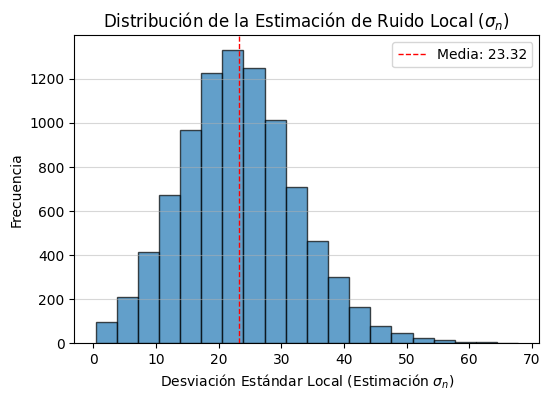

El alto valor de la media (23.32) indica una alta granularidad/textura en el dataset.


In [17]:

plt.figure(figsize=(6, 4))
plt.hist(ruidos_array, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(media_ruido, color='red', linestyle='dashed', linewidth=1, label=f'Media: {media_ruido:.2f}')
plt.title('Distribución de la Estimación de Ruido Local ($\sigma_n$)')
plt.xlabel('Desviación Estándar Local (Estimación $\sigma_n$)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

print("El alto valor de la media (23.32) indica una alta granularidad/textura en el dataset.")

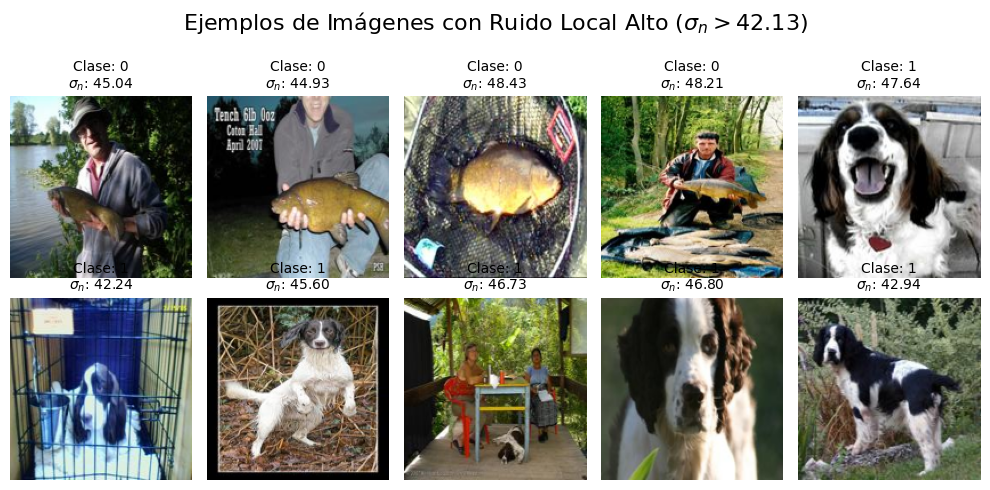

In [18]:
# Celda 3: Visualización de Ejemplos de Ruido Alto (Outliers)

num_a_mostrar = min(10, len(indices_ruido_alto))
indices_a_mostrar = indices_ruido_alto[:num_a_mostrar]

if num_a_mostrar > 0:
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Ejemplos de Imágenes con Ruido Local Alto ($\sigma_n > {umbral_alto:.2f}$)", fontsize=16)

    for i, idx_original in enumerate(indices_a_mostrar):
        img, label_idx = train_dataset[idx_original]
        
        # Volvemos a convertir a NumPy si es necesario
        if not isinstance(img, np.ndarray):
            try:
                img = np.array(transforms.ToPILImage()(img))
            except:
                 if hasattr(img, 'numpy'):
                     img = img.numpy().transpose((1, 2, 0))
                 else:
                     img = np.array(img)

        # Buscar el valor de ruido específico
        ruido_especifico = [r[1] for r in ruidos_estimados_con_indice if r[0] == idx_original][0]
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img) 
        plt.title(f"Clase: {label_idx}\n$\\sigma_n$: {ruido_especifico:.2f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No hay suficientes imágenes con ruido extremadamente alto (o el umbral es muy estricto) para mostrar.")

# 4. Principales Insights del EDA


## 1. Geometría y Distribución (Puntos 1 y 2)

### Hallazgos Clave
* **Balance de Clases:** El *dataset* está **perfectamente balanceado** (aprox. 950 imágenes por clase), sin ninguna clase minoritaria significativa.
* **Uniformidad Geómetrica:** Todas las imágenes son de **$160 \times 160$ píxeles** con una relación de aspecto cuadrada ($1.0$).

### Decisiones de Preprocesamiento
| Decisión | Justificación del EDA |
| :--- | :--- |
| **No se requiere *weighted loss*** | El balance perfecto de clases elimina la necesidad de técnicas de mitigación de desbalance (ej. SMOTE, pérdida ponderada). La **precisión** global es una métrica confiable. |
| **Transformación de *Resize*** | Ya que todas las imágenes son uniformes ($160 \times 160$), el *resize* no es un paso de corrección, sino de **adaptación** si se usa una arquitectura pre-entrenada (ej. a $224 \times 224$ o $256 \times 256$). |
| **Random Resized Crop (RRC)** | Obligatorio, dado que la variación de escala es $0$. El RRC es esencial para introducir **variabilidad de tamaño** y **eliminar los posibles bordes no informativos** (picos en $0.0/1.0$ del histograma). |


## 2. Color y Brillo (Puntos 3, 4 y 5)

### Hallazgos Clave
* **Iluminación/Varianza:** La media RGB general ($\mu \approx 0.45$) indica una ligera oscuridad, pero la desviación estándar ($\sigma \approx 0.27$) revela una **alta varianza de contraste y brillo**.
* **Picos Extremos:** El histograma RGB muestra picos fuertes en los valores $0.0$ y $1.0$ (especialmente en el canal Azul), indicando la presencia de **fondos negros/blancos y luces/sombras extremas**.
* **Baja Saturación:** La distribución de saturación es **asimétrica**, concentrándose en valores bajos ($\approx 50$), lo que implica que la mayoría de las imágenes tienen colores apagados o moderados.
* **Calidad:** Solo el **$1.73\%$** de las imágenes son problemáticas (extremos de brillo/contraste), por lo que **no se requiere limpieza manual**.

### Decisiones de Preprocesamiento y Augmentation
| Decisión | Justificación del EDA |
| :--- | :--- |
| **Normalización (RGB)** | Necesaria para centrar los datos y optimizar la convergencia del modelo. Se aplicará con los valores calculados: $\mu=[0.4625, 0.4580, 0.4298]$ y $\sigma=[0.2748, 0.2690, 0.2856]$. |
| **Augmentation de Saturación** | **Prioridad Alta.** La baja saturación del *dataset* exige una **variación agresiva** (ej. rango $\mathbf{(0.5, 1.5)}$) para evitar que el modelo se sobreajuste a los colores apagados. |
| **Augmentation de Brillo/Contraste** | **Prioridad Media.** Necesario para mitigar el $1.73\%$ de *outliers* extremos y manejar la alta varianza natural del contraste (ej. rango $\mathbf{(0.7, 1.3)}$). |


## 3. Textura y Frecuencia (Puntos 6 y 7)

### Hallazgos Clave
* **FFT (Global):** La mayor energía se concentra en las **bajas frecuencias** (formas grandes, fondos uniformes), con líneas axiales que sugieren estructuras fuertes (horizontales/verticales) o artefactos de *resizing*.
* **Ruido Local ($\sigma_n$):** La media de la desviación estándar local es **alta** ($\mu \approx 23.4$), lo que indica una **rica y alta granularidad/textura** a nivel de parche.
* **Outliers Texturales:** Se identificó un pequeño grupo de imágenes (aprox. $280$) con textura excepcionalmente alta ($\sigma_n > 42.4$).

### Decisiones de Modelado y Augmentation
| Decisión | Justificación del EDA |
| :--- | :--- |
| **Augmentation de Ruido** | **Esencial.** Aplicar **Ruido Gaussiano aleatorio** con baja probabilidad, imitando el pequeño grupo de *outliers* de alta $\sigma_n$, haciendo el modelo robusto a variaciones texturales y ruido ausente en el FFT. |
| **Augmentation Geométrico** | **Necesario.** Incluir transformaciones como **rotaciones leves** o **shear** para forzar al modelo a centrarse en la **forma** del objeto (baja frecuencia) independientemente de su orientación, rompiendo la uniformidad axial del FFT. |
| **Elección de Arquitectura** | La alta granularidad ($\sigma_n$) sugiere que las arquitecturas basadas en convolución (ej. **ResNet, VGG**) serán efectivas, ya que sus filtros pequeños ($3 \times 3$) están bien equipados para capturar la rica información textural local. |

# 5. Separación de Datos (Train/Val/Test)

1. **Train dataset original**  
   - Contiene todas las imágenes de entrenamiento (`split="train"`).  
   - Se usa para crear un **split interno** de entrenamiento y validación.

2. **Split interno (train / val)**  
   - 80% de las imágenes → subset de entrenamiento (`train_subset`)  
   - 20% de las imágenes → subset de validación (`val_subset`)  
   - Permite monitorear **loss y accuracy** durante el entrenamiento sin tocar el test final.

3. **Test final (`val_dataset`)**  
   - El split `val` de Imagenette se mantiene intacto y se usa como **test final**.  
   - Garantiza que la evaluación final sea objetiva e independiente de los datos de entrenamiento.

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def get_imagenette_dataloaders(train_dataset, val_dataset, batch_size, num_workers):
    """
    Devuelve los DataLoaders de entrenamiento, validación interna y test
    para Imagenette160, usando las transformaciones definidas en el EDA.
    """
    # 1. Normalización
    imagenette_mean = [0.467, 0.448, 0.397]
    imagenette_std  = [0.230, 0.226, 0.228]
    normalize = transforms.Normalize(mean=imagenette_mean, std=imagenette_std)

    # 2. Transformaciones de entrenamiento (con Resize incluido por legacy)
    train_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.RandomResizedCrop(160, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),         
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),
        transforms.ToTensor(),
        normalize
    ])

    # 3. Transformaciones de validación y test
    val_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        normalize
    ])

    test_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        normalize
    ])

    # 4. Split interno train/val (80/20)
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # Asignar las transformaciones correspondientes
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform
    val_dataset.transform = test_transform  # por si no estaba seteado antes

    # 5. DataLoaders
    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val_loader_internal = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    test_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader_internal, test_loader


# 6. Funciones Genéricas

In [5]:
def train_model(model, train_loader, val_loader, config, device, patience=5):
    """
    Entrena un modelo con early stopping, logging en wandb y retorno del historial + mejor modelo.
    
    Args:
        model: nn.Module, modelo a entrenar
        train_loader: DataLoader del conjunto de entrenamiento
        val_loader: DataLoader del conjunto de validación
        config: dict con hiperparámetros (lr, optimizer, epochs, etc.)
        device: "cuda" o "cpu"
        patience: int, cantidad de epochs sin mejora para early stopping

    Returns:
        best_model: modelo con menor val_loss
        history: diccionario con listas de train/val loss y accuracy
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    else:
        raise ValueError(f"Optimizer {config['optimizer']} not supported")

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["epochs"]):
        # ---- Entrenamiento ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---- Validación ----
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct_val += preds.eq(labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = correct_val / total_val

        # ---- Guardar en historial ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Log en W&B ----
        wandb.log({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "epoch": epoch
        })

        print(f"[{epoch+1}/{config['epochs']}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # ---- Early stopping y guardar mejor modelo ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # guarda pesos
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹ Early stopping en epoch {epoch+1}")
                break

    # ---- Devolver mejor modelo ----
    best_model = model
    if best_model_state is not None:
        best_model.load_state_dict(best_model_state)

    return best_model, history


In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return {"loss": avg_loss, "accuracy": accuracy}


In [28]:
import wandb
import json
import re
import os


def upload_best_model_from_sweep(
    sweep_id: str,
    model_name: str,
    project: str = "imagenette",
    models_dir: str = "models",
    add_tag: str | None = "best_model",
):
    """
    Busca la mejor run (mínimo val_loss) en un sweep de W&B y sube su modelo como artifact.
    Usa la misma lógica probada que extrajo correctamente los val_loss.

    Args:
        sweep_id (str): ID del sweep (por ejemplo 'abcd1234').
        model_name (str): Nombre lógico del modelo (por ejemplo 'lenet' o 'tinycnn').
        project (str): Nombre del proyecto de W&B (por defecto 'imagenette').
        models_dir (str): Carpeta local donde están los archivos .pth.
        add_tag (str | None): Tag opcional a agregar al artifact.
    """

    api = wandb.Api()
    sweep = api.sweep(f"{project}/{sweep_id}")

    # --- FUNCIÓN ORIGINAL PARA EXTRAER val_loss ---
    def get_val_loss(run):
        """
        Extrae val_loss de una run W&B de forma robusta.
        Siempre devuelve un float (inf si no se encuentra).
        """
        try:
            # 1) intento directo desde summary
            try:
                if hasattr(run, "summary") and getattr(run.summary, "get", None):
                    v = run.summary.get("val_loss")
                    if v is not None:
                        return float(v)
            except Exception:
                pass

            # 2) fallback a _json_dict (puede ser dict o str multiline)
            summary = getattr(run.summary, "_json_dict", None)
            if isinstance(summary, dict):
                v = summary.get("val_loss")
                if v is not None:
                    return float(v)
            elif isinstance(summary, str):
                lines = [l.strip() for l in summary.splitlines() if l.strip()]
                for line in reversed(lines):
                    try:
                        obj = json.loads(line)
                        if "val_loss" in obj:
                            return float(obj["val_loss"])
                    except Exception:
                        m = re.search(r'"val_loss"\s*:\s*([0-9.+-eE]+)', line)
                        if m:
                            return float(m.group(1))
                # última oportunidad: buscar en todo el string
                m = re.search(r'"val_loss"\s*:\s*([0-9.+-eE]+)', summary)
                if m:
                    return float(m.group(1))

        except Exception:
            pass

        # Si todo falla, devolver inf (float) en lugar de None
        return float("inf")

    # --- ELEGIR MEJOR RUN ---
    losses = []
    for run in sweep.runs:
        try:
            l = get_val_loss(run)
        except Exception:
            l = float("inf")
        losses.append((l, run))
        print(f"• {run.name} ({run.id}) → val_loss = {l if l != float('inf') else 'None'}")

    # Elegir la mejor run (la que tenga menor val_loss)
    best_loss, best_run = min(losses, key=lambda x: x[0])
    if best_loss == float("inf"):
        print(f"⚠️ No se pudo extraer val_loss de ninguna run del sweep {sweep_id}.")
        return

    print(f"\n🏆 Mejor run encontrada:")
    print(f"   • Run: {best_run.name} ({best_run.id})")
    print(f"   • val_loss = {best_loss:.4f}")
    print(f"   • Sweep ID: {sweep_id}")

    # --- BUSCAR ARCHIVO DEL MODELO ---
    best_model_path = os.path.join(models_dir, f"sweep_run_{best_run.id}.pth")
    if not os.path.exists(best_model_path):
        print(f"❌ No se encontró el archivo del modelo en {best_model_path}")
        return

    # --- SUBIR ARTIFACT ---
    run_upload = wandb.init(
        project=project,
        name=f"upload_best_{model_name}_{sweep_id}",
        reinit=True,
        tags=["artifact_upload", add_tag] if add_tag else ["artifact_upload"]
    )

    artifact_name = f"{model_name}_best_model_{sweep_id}"
    artifact = wandb.Artifact(
        name=artifact_name,
        type="model",
        description=f"Mejor modelo ({model_name}) del sweep {sweep_id} (run {best_run.id})",
        metadata={
            "sweep_id": sweep_id,
            "run_id": best_run.id,
            "val_loss": best_loss,
        }
    )

    artifact.add_file(best_model_path)
    wandb.log_artifact(artifact)
    wandb.finish()

    print(f"\n✅ Artifact '{artifact_name}' subido correctamente a W&B.")


# 7. Modelo Baseline

In [7]:
def build_tiny_cnn(config, num_classes=10):
    class TinyCNN(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.features = nn.Sequential(
                # Un solo bloque conv
                nn.Conv2d(3, 8, kernel_size=3, padding=1),  # 3 → 8 canales
                nn.ReLU(inplace=True),
                nn.MaxPool2d(4),  # 160x160 → 40x40
                nn.Dropout(cfg.dropout1)
            )

            # Capa lineal muy chica
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(8 * 40 * 40, num_classes)  # directamente a las clases
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return TinyCNN(config)


## Selección de Hiperparámetros

In [9]:
def sweep_train():
    wandb.init(
        project="imagenette",
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["BASELINE"]
    )
    config = wandb.config

    model = build_tiny_cnn(config).to(device)

    NUM_WORKERS = 4
    # ✅ Usamos directamente los dataloaders
    train_loader, val_loader, _ = get_imagenette_dataloaders(
        train_dataset, val_dataset, config.batch_size, NUM_WORKERS
    )

    best_model, history = train_model(
        model, train_loader, val_loader, config, device, patience=3
    )

    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    os.makedirs("models", exist_ok=True)
    torch.save(best_model.state_dict(), local_path)

    print(f"✅ Modelo guardado localmente en {local_path}")
    wandb.finish()


In [ ]:
sweep_config = {
    "name": "baseline_tinycnn_sweep",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "lr": {"values": [1e-2, 1e-3, 1e-4]},
        "optimizer": {"values": ["Adam", "SGD"]},
        "batch_size": {"values": [128, 256]},
        "dropout1": {"values": [0.0, 0.25, 0.5]},
        "epochs": {"value": 30}
    },
    "tags": ["baseline", "test"]  

}

sweep_id = wandb.sweep(sweep_config, project="imagenette")
wandb.agent(sweep_id, function=sweep_train, count=20)


In [29]:
upload_best_model_from_sweep(
    sweep_id="2nkvrlxi",
    model_name="tinycnn",
    project="imagenette"
)

• balmy-sweep-1 (jfuqylta) → val_loss = 1.4347560428401749
• balmy-sweep-2 (2uun73w5) → val_loss = 1.6194451041657396
• rich-sweep-3 (8x44rae9) → val_loss = 1.7462473793503348
• northern-sweep-4 (gvy6t6wt) → val_loss = 1.6610775225639849
• pious-sweep-5 (842sbig4) → val_loss = 1.474116790376513
• toasty-sweep-6 (0sqlxbz7) → val_loss = 1.524212846224483
• chocolate-sweep-7 (hfo32e27) → val_loss = 1.4184345358965955
• peachy-sweep-8 (4iiyoc0v) → val_loss = 1.3332587738737378
• logical-sweep-9 (thmmsmai) → val_loss = 1.3846745611307676
• zesty-sweep-10 (7a1xirpa) → val_loss = 1.4556964798950984
• firm-sweep-11 (wi1dmhll) → val_loss = 1.3559351168293456
• super-sweep-12 (c5p6jdj5) → val_loss = 1.397916422278177
• lyric-sweep-13 (yazidinm) → val_loss = 1.4190715276810837
• vivid-sweep-14 (uxzstox3) → val_loss = 1.3838546250903034
• jumping-sweep-15 (ijog2lit) → val_loss = 1.3464707162603144
• brisk-sweep-16 (9sxt1n8c) → val_loss = 1.451902997411878
• proud-sweep-17 (6ksbqndb) → val_loss = 1


✅ Artifact 'tinycnn_best_model_2nkvrlxi' subido correctamente a W&B.


## Evaluación en Test

In [35]:
from types import SimpleNamespace 
best_model_path = "3_best_models/tinycnn_best_model.pth"

#load model
config_dict = {"dropout1": 0}
config_obj = SimpleNamespace(**config_dict)
model = build_tiny_cnn(config_obj) 
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)

#batch size es el mismo que el usado en el sweep, en este caso 256

_, _, test_loader = get_imagenette_dataloaders(
    train_dataset, val_dataset, batch_size=256, num_workers=4
)

results = evaluate(model, test_loader, device)
print(f"Test Loss: {results['loss']:.4f}, Test Accuracy: {results['accuracy']:.4f}")

C:\Users\kidni\AppData\Local\Temp\ipykernel_18264\3963363156.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locati

Test Loss: 1.3724, Test Accuracy: 0.5490


# 8. LeNet-5